In [1]:
import pandas as pd
import umap
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from ABCA7lof2.qc import gmm_bic_score


/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

In [2]:
# functions
def hyper_p(curr, genes, mat_hat_hat, index, temp):
    n = len(curr) # number of cluster genes
    M = len(genes) # total number of genes
    N = np.sum(mat_hat_hat[:,index]) # total number of pathway members
    x = np.sum(temp[:,index]) # observed overlap of cluster genes and pathway
    return 1 - hypergeom.cdf(x, M, n, N), x

# from: https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

def score_clusters(lab, M):
    lab_indices = np.empty(shape=(len(lab), len(np.unique(lab))))
    for i, L in enumerate(np.unique(lab)):
        lab_indices[:,i] = lab==L

    df = np.matmul((M.T), lab_indices)/np.sum(lab_indices, axis=0)
    return df

In [3]:
# specify umap params
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=30, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=2, n_components=2, n_epochs=1000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1,
     set_op_mix_ratio=1.0, spread=10, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)#, disconnection_distance=5)

In [232]:
# load data
expression = pd.read_csv('./processed_data/single_cell/all_scores_0825.csv', index_col=0)
# fgsea = pd.read_csv('./processed_data/for_plotting/fgsea_out_0825.csv', index_col=0, encoding='windows-1254')
# sele_paths = set(fgsea['pathway'])
# leading_edge = pd.read_csv( './processed_data/for_plotting/leading_edge_0825.csv', index_col=0)

In [233]:
# index top genes
index = np.array(np.sum(np.abs(expression)>1.3, axis=1)>0)
genes = np.array(expression.index)[index]
M = np.array(expression.loc[genes])

In [234]:
# fit
embedding = reducer.fit_transform(M)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [235]:
# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'RdBu_r'#C2[i]
cm = plt.cm.get_cmap(COL, embedding.shape[0])
colors = [cm(int(x)) for x in range(embedding.shape[0])]

/state/partition1/slurm_tmp/23722499.0.0/ipykernel_641530/4266044538.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding.shape[0])


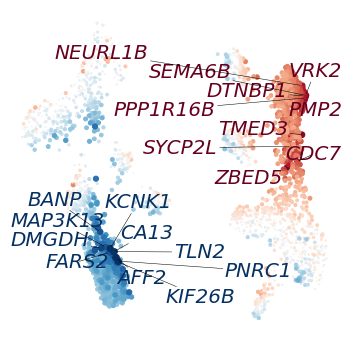

<Figure size 432x288 with 0 Axes>

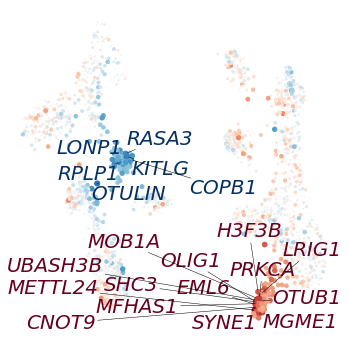

<Figure size 432x288 with 0 Axes>

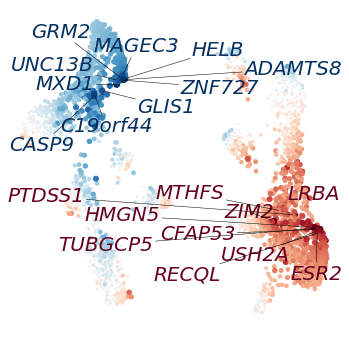

<Figure size 432x288 with 0 Axes>

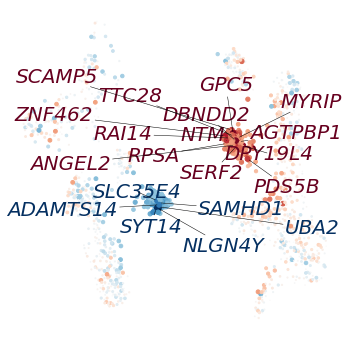

<Figure size 432x288 with 0 Axes>

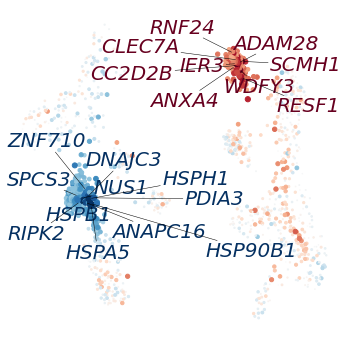

<Figure size 432x288 with 0 Axes>

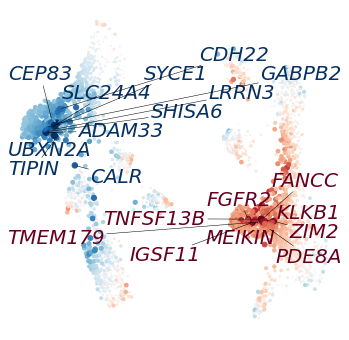

<Figure size 432x288 with 0 Axes>

In [236]:
from adjustText import adjust_text

celltypes = np.array(expression.columns)

for i, cell in enumerate(celltypes):
    plt.figure(figsize = (6,6))

    plt.scatter(embedding[:,0], embedding[:,1], c=M[:,i], cmap=COL, s = np.abs(M[:,i]*10), vmin=-3.5, vmax=3.5)
    #plt.colorbar()

    texts = []
    show = set(genes[np.argsort(-1*np.abs(M[:,i]))][:20])
    #order = np.argsort(-1*(M[:,i]))
    for x, txt in enumerate(genes):
         if txt in show:
            #C = colors[np.where([x in set([txt]) for x in list(show2)])[0][0]]
            w = np.where([f==txt for f in genes])[0][0]
            if M[x,i]<0:
                texts.append(plt.text(embedding[x,0], embedding[x,1], txt, style='italic', color = colors[0], fontsize=20))
            else:
                texts.append(plt.text(embedding[x,0], embedding[x,1], txt, style='italic', color = colors[-1], fontsize=20))
                
    adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    a = plt.gca()
    a.axis('off')
    #plt.title(cell, fontsize=20)
    plt.savefig('./pdf_figures//'+str(cell)+'umap.png', dpi=300)
    plt.figure()
    

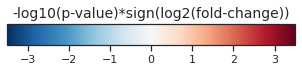

In [227]:
# save colorbar
import pylab as pl
a = np.array([[-3.5,3.5]])
pl.figure(figsize=(5, .5))
img = pl.imshow(a, cmap="RdBu_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
plt.title('-log10(p-value)*sign(log2(fold-change))', fontsize=14)
plt.savefig('./pdf_figures//umap_cbar.pdf', bbox_inches='tight')

In [33]:
from matplotlib.colors import LinearSegmentedColormap

cm0 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#8491B4FF")], N=10)

cm1 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#E64B35FF")], N=10)

cm2 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#F39B7FFF")], N=10)

cm3 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#4DBBD5FF")], N=10)

cm4 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#00A087FF")], N=10)

cm5 = LinearSegmentedColormap.from_list(
        'test', [("#FFFFFF"),("#3C5488FF")], N=10)

COL = [cm0, cm1, cm2, cm3, cm4, cm5]

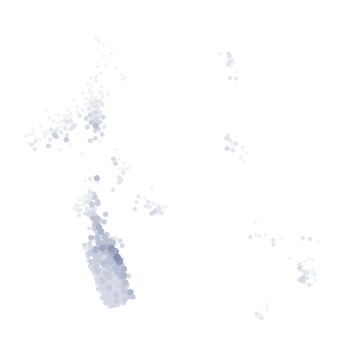

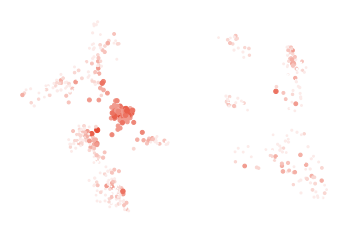

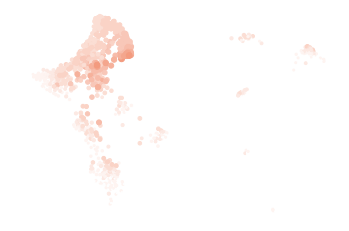

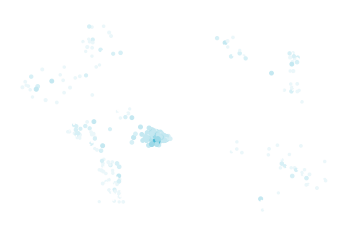

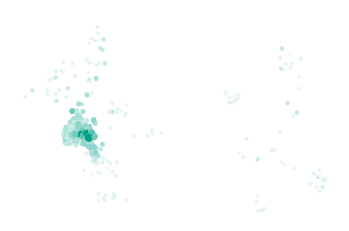

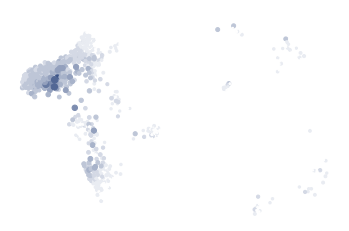

<Figure size 432x288 with 0 Axes>

In [36]:
# show all together
plt.figure(figsize = (6,6))

for i, cell in enumerate(celltypes):
    
    index = np.where(M[:,i]<0)[0]
    plt.scatter(embedding[index,0], embedding[index,1], c=np.abs(M[index,i]), cmap=COL[i], s = np.abs(M[index,i]*10),label=cell)
    a = plt.gca()
    a.axis('off')
    #plt.title(cell, fontsize=20)
    #plt.title(cell)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_down.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


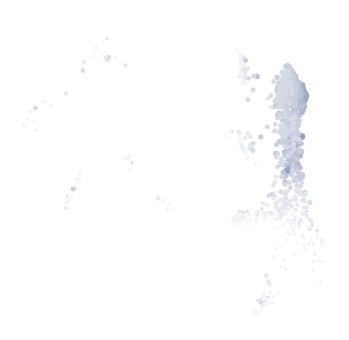

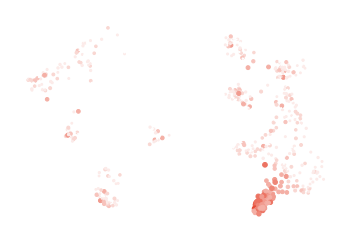

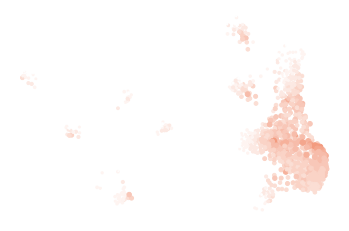

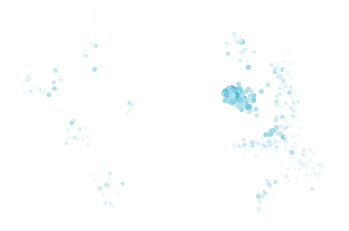

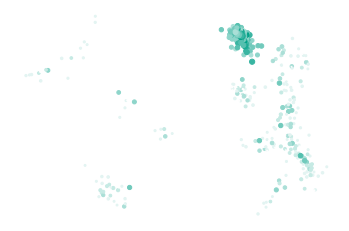

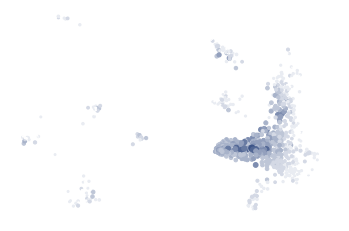

<Figure size 432x288 with 0 Axes>

In [37]:
# show all together
plt.figure(figsize = (6,6))

for i, cell in enumerate(celltypes):
    
    index = np.where(M[:,i]>0)[0]
    plt.scatter(embedding[index,0], embedding[index,1], c=np.abs(M[index,i]), cmap=COL[i], s = np.abs(M[index,i]*10),label=cell)
    a = plt.gca()
    a.axis('off')
    #plt.title(cell, fontsize=20)
    #plt.title(cell)
    plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_up.pdf')
    #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
    plt.figure()
    #plt.legend()
    
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [38]:
# # show all together
# plt.figure(figsize = (6,5))

# for i, cell in enumerate(celltypes):
    
#     #index = np.where(M[:,i]<0)[0]
#     plt.scatter(embedding[:,0], embedding[:,1], c=np.abs(M[:,i]), cmap=COL[i], s = np.abs(M[:,i]*1),label=cell)
#     a = plt.gca()
#     a.axis('off')
#     #plt.title(cell, fontsize=20)
#     #plt.title(cell)
#     #plt.savefig('./pdf_figures//'+str(cell)+'umap_colored_down.pdf')
#     #plt.savefig('./pdf_figures/all_cells_down_umap.pdf',  bbox_inches='tight')
#     #plt.figure()
#     #plt.legend()
    
# #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [67]:
# gridsearch for clustering
X = embedding
param_grid = {
        "n_components": range(12, 20),
        "covariance_type": ["spherical", "tied", "diag", "full"],
        "n_init":[100],
    }
print('gaussian gridsearch')
    
grid_search = GridSearchCV(
GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, n_jobs=50
)
grid_search.fit(X)


df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    ###############

x = df.loc[np.argmin(df['BIC score'])]
print(x)

gaussian gridsearch
Number of components              15
Type of covariance              tied
BIC score               11616.393237
Name: 11, dtype: object


(-82.77736129760743, 75.50110092163087, -53.19494495391846, 43.2832971572876)

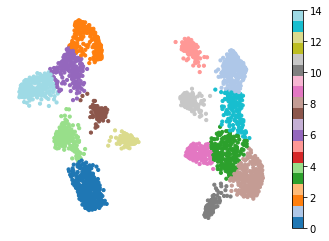

In [69]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=15, covariance_type='tied', random_state=0, n_init=100).fit(embedding)
lab = gm.predict(embedding)

plt.scatter(embedding[:,0], embedding[:,1], c=lab, cmap='tab20', s=10)#s = np.abs(expression[i][gene_index_a][gene_index2][gene_index3]*10))
plt.colorbar()
a = plt.gca()
a.axis('off')


In [143]:
# get pathways
from ABCA7lof2.geneclusters import get_gene_pathway_matrix
path = './raw_data/genesets/GO_Biological_Process_2023.npy'
mat = get_gene_pathway_matrix(path)
content = mat[np.sum(mat, axis=1)>14]

In [146]:
# split genes by cluster
from scipy.stats import hypergeom
import gseapy as gp

content_T = np.array(content).T
paths = np.array(content.index)
gset = np.load(path, allow_pickle=True).item()
test_genes = {}
[test_genes.update({i:list(genes[lab==i])}) for i in np.unique(lab)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [252]:
# run enrichment per cluster
from tqdm import tqdm
genes_enrich = np.empty((500, 11), dtype=object)

index = 0
names = []
for x in tqdm(range(len(test_genes))):
    enr2 = gp.enrich(gene_list=test_genes[x],
                     gene_sets=gset, # kegg is a dict object
                     background=genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     outdir=None,
                     verbose=True)
    temp = enr2.results.sort_values('P-value')
    temp = temp[temp['P-value']<0.01]
    temp['N'] = [int(x.split('/')[0]) for x in np.array(temp['Overlap'])]
    temp = temp.sort_values('N', ascending=False)
    n = np.array(temp['Term'])[0].split(' (')[0] + '\n' + np.array(temp['Term'])[1].split(' (')[0] + '\n' + np.array(temp['Term'])[2].split(' (')[0]
    names.append(n)
    for it in range(3):
        g = np.array(temp['Genes'])[it].split(';')
        for i in g:
            genes_enrich[index][0] = x
            genes_enrich[index][1] = np.array(temp['Term'])[it].split(' (')[0]
            genes_enrich[index][2] = np.array(temp['P-value'])[it]
            genes_enrich[index][3] = np.array(temp['N'])[it]
            genes_enrich[index][4] = i
            genes_enrich[index][5:11] = np.array(expression.loc[i])
            index+=1

  0%|          | 0/15 [00:00<?, ?it/s]2023-08-27 14:32:28,072 [INFO] Input dict object named with gs_ind_0
2023-08-27 14:32:28,073 [INFO] Run: gs_ind_0 
2023-08-27 14:32:28,693 [INFO] Done.
  7%|▋         | 1/15 [00:00<00:08,  1.59it/s]2023-08-27 14:32:28,700 [INFO] Input dict object named with gs_ind_0
2023-08-27 14:32:28,701 [INFO] Run: gs_ind_0 
2023-08-27 14:32:29,168 [INFO] Done.
 13%|█▎        | 2/15 [00:01<00:06,  1.86it/s]2023-08-27 14:32:29,173 [INFO] Input dict object named with gs_ind_0
2023-08-27 14:32:29,174 [INFO] Run: gs_ind_0 
2023-08-27 14:32:29,664 [INFO] Done.
 20%|██        | 3/15 [00:01<00:06,  1.93it/s]2023-08-27 14:32:29,669 [INFO] Input dict object named with gs_ind_0
2023-08-27 14:32:29,669 [INFO] Run: gs_ind_0 
2023-08-27 14:32:30,184 [INFO] Done.
 27%|██▋       | 4/15 [00:02<00:05,  1.93it/s]2023-08-27 14:32:30,190 [INFO] Input dict object named with gs_ind_0
2023-08-27 14:32:30,190 [INFO] Run: gs_ind_0 
2023-08-27 14:32:30,717 [INFO] Done.
 33%|███▎      | 5

In [248]:
df = pd.DataFrame(genes_enrich[:index])
df.columns = ['cluster', 'pathway', 'pvalue', 'overlap', 'gene', 'Opc', 'Ast', 'Ex', 'Oli', 'Mic', 'In']

In [249]:
df

,cluster,pathway,pvalue,overlap,gene,Opc,Ast,Ex,Oli,Mic,In
0,0,Cilium Assembly,0.003492,12,TBC1D32,-1.320754,-0.324091,0.263806,0.091752,-0.856756,-0.638191
1,0,Cilium Assembly,0.003492,12,ARMC9,-1.419748,-0.973229,0.12365,0.0,0.0,1.417342
2,0,Cilium Assembly,0.003492,12,CEP126,-2.352156,0.372168,0.181729,-0.554797,0.0,0.036345
3,0,Cilium Assembly,0.003492,12,BBS1,-1.724143,0.14035,0.403744,0.0,0.0,0.212655
4,0,Cilium Assembly,0.003492,12,DISC1,-2.028092,0.0,-0.04379,0.484444,0.142296,-0.264943
...,...,...,...,...,...,...,...,...,...,...,...
310,14,External Encapsulating Structure Organization,0.000637,6,HPSE2,0.0,0.143284,0.0,0.0,0.0,-1.312028
311,14,External Encapsulating Structure Organization,0.000637,6,MMP17,0.680878,0.0,-0.967926,0.0,0.0,-2.038405
312,14,External Encapsulating Structure Organization,0.000637,6,COL7A1,0.0,0.0,-0.014598,0.0,0.0,-1.925601
313,14,External Encapsulating Structure Organization,0.000637,6,COL5A2,0.0,-0.31228,-0.109831,0.0,0.0,-2.046779


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-82.77736129760743, 75.50110092163087, -53.19494495391846, 43.2832971572876)

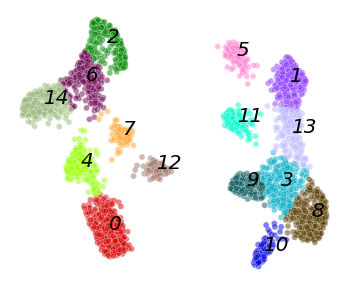

In [250]:
# plot clusters with annotation
import seaborn as sns
import colorcet as cc

dictionary = dict(zip(np.unique(lab), names))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))

plt.figure(figsize = (6,5))



#for i in range(embedding.shape[0]):
order = np.argsort(lab)

sns.scatterplot(embedding[order,0], embedding[order,1], hue = N[order], palette=palette, legend=False, alpha=0.5)#, label = list(dictionary.values()))
legend = plt.legend(ncol=1, bbox_to_anchor=(1, 1), frameon=False, fontsize=12, scatterpoints=1, markerscale=2)

for i in range(len(palette)):
    x = np.mean(embedding[order][lab[order]==i,0])
    y = np.mean(embedding[order][lab[order]==i,1])
    
    plt.text(x,y, i, style='oblique',  c='black', fontsize=20)
    
a = plt.gca()
a.axis('off')
#plt.autoscale()

#plt.savefig('./pdf_figures/Figure_1_cluster_overview.pdf', bbox_inches='tight')


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-82.77736129760743, 75.50110092163087, -53.19494495391846, 43.2832971572876)

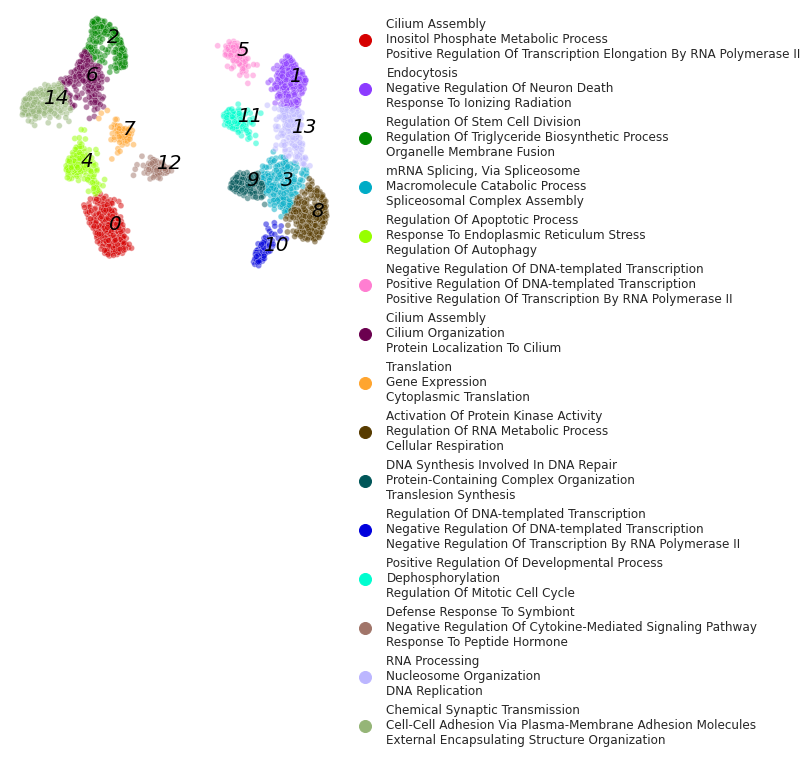

In [253]:
# plot clusters with annotation
import seaborn as sns
import colorcet as cc

dictionary = dict(zip(np.unique(lab), names))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))

plt.figure(figsize = (6,5))



#for i in range(embedding.shape[0]):
order = np.argsort(lab)

sns.scatterplot(embedding[order,0], embedding[order,1], hue = N[order], palette=palette, legend=True, alpha=0.5)#, label = list(dictionary.values()))
legend = plt.legend(ncol=1, bbox_to_anchor=(1, 1), frameon=False, fontsize=12, scatterpoints=1, markerscale=2)

for i in range(len(palette)):
    x = np.mean(embedding[order][lab[order]==i,0])
    y = np.mean(embedding[order][lab[order]==i,1])
    
    plt.text(x,y, i, style='oblique',  c='black', fontsize=20)
    
a = plt.gca()
a.axis('off')


In [254]:
# save the legend
export_legend(legend, './pdf_figures/Figure_1_legend.pdf')

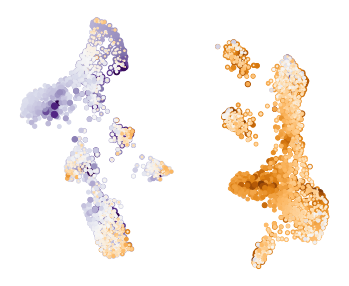

In [119]:
plt.figure(figsize = (6,5))
celltypes = np.array(expression.columns)

for i, cell in enumerate(celltypes):
    

    plt.scatter(embedding[:,0], embedding[:,1], c=M[:,i], cmap='PuOr_r', s = np.abs(M[:,i]*10))
    a = plt.gca()
    a.axis('off')
    #plt.title('All celltypes', fontsize=20)
  
plt.savefig('./pdf_figures//umap_exp_overview.png')
    #plt.figure()
    


In [163]:

# celltypes = np.array(expression.columns)

# for i, cell in enumerate(celltypes):
#     plt.figure(figsize = (6,5))

#     sns.scatterplot(embedding[:,0], embedding[:,1], hue = N, palette=palette, legend=False, s=np.abs(M[:,i]*5), alpha=np.abs(M[:,i])/np.max(np.abs(M)))

#     a = plt.gca()
#     a.axis('off')
#     plt.title(cell, fontsize=20)
#     plt.savefig('./pdf_figures//'+str(cell)+'umap_clust.pdf')
#     plt.figure()
    

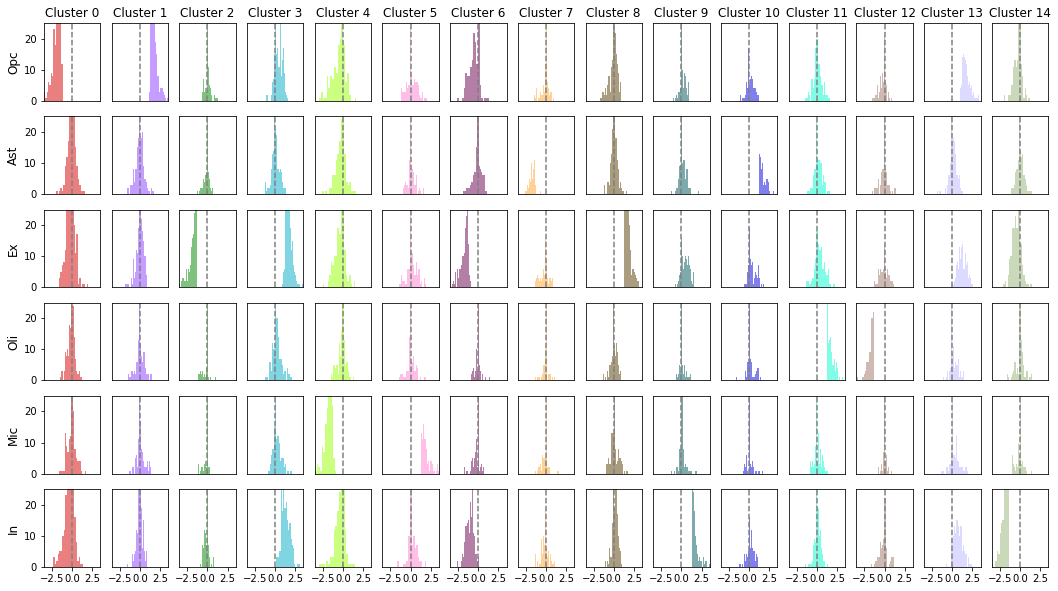

In [164]:
df = pd.DataFrame(score_clusters(lab, M))
df.index = celltypes
df.columns = np.unique(lab)

df['celltype'] = df.index
temp = pd.melt(df, id_vars='celltype')

fig, axs = plt.subplots(6, 15)
fig.set_size_inches(18, 10)

for x in range(len(celltypes)):

    for i in np.unique(lab):
        axs[x,i].hist(M.T[x][lab==i], alpha=0.5, color=palette[i], bins=20, label=str(i))
        #axs[x,i].axvline(x=np.mean(M.T[x][lab==i]), color=palette[i])
        axs[x,i].axvline(x=0, color='grey', linestyle='--')
        axs[x,i].set_xlim([-3.5,3.5])
        axs[x,i].set_ylim([0,25])
        #ax.yaxis.set_label_position("right")
        
        if x < 5:
            axs[x,i].xaxis.set_visible(False)
        if i > 0:
            axs[x,i].yaxis.set_visible(False)
            
    #plt.title(celltypes[x])
    #plt.legend()
    #plt.savefig('./pdf_figures//'+str(celltypes[x])+'hist.pdf')
    #plt.figure()
   
rows = ['{}'.format(col) for col in celltypes]
cols = ['Cluster {}'.format(row) for row in np.unique(lab)]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.savefig('./pdf_figures/cluster_hist.pdf')

In [166]:
from scipy import interpolate
from scipy.stats import rankdata

N = 100000
out = np.empty((N, df.shape[0]*df.shape[1]))
out = np.vstack([score_clusters(np.random.permutation(lab), M).ravel() for i in range(N)])
true = score_clusters(lab, M).ravel()
pvals = []
for i in range(out.shape[1]):
    #print(i)
    val = true[i]
    x = out[:,i]
    if ((val>np.max(x)) | (val<np.min(x))):
        pvals.append(0)
    else:
        y = (rankdata(x)/N)
        func = interpolate.interp1d(x,y)

        if val>0:
            pvals.append((1-func(val)))
        else:
            pvals.append(float(func(val)))

In [167]:
df = pd.DataFrame(score_clusters(lab, M))
df.index = celltypes
df.columns = np.unique(lab)
df = df.T
df['cluster'] = df.index
temp = pd.melt(df, id_vars='cluster')
temp['pval'] = pvals

In [180]:
import seaborn as sns

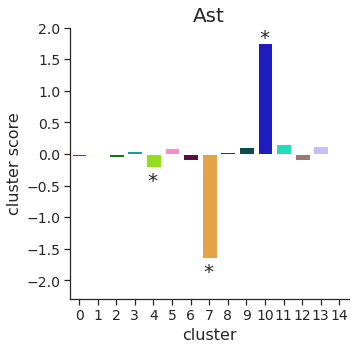

<Figure size 432x288 with 0 Axes>

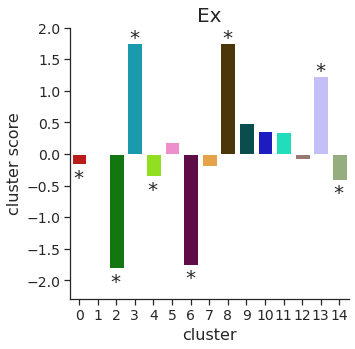

<Figure size 432x288 with 0 Axes>

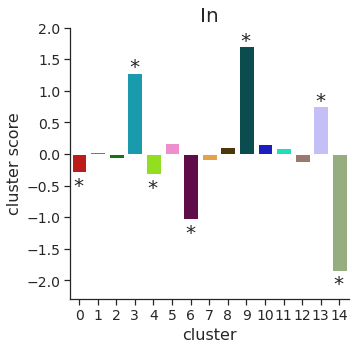

<Figure size 432x288 with 0 Axes>

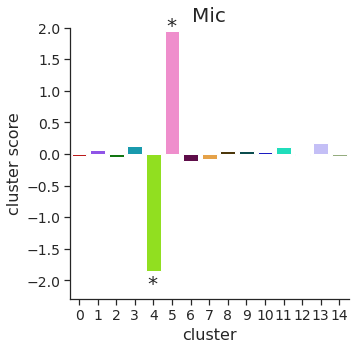

<Figure size 432x288 with 0 Axes>

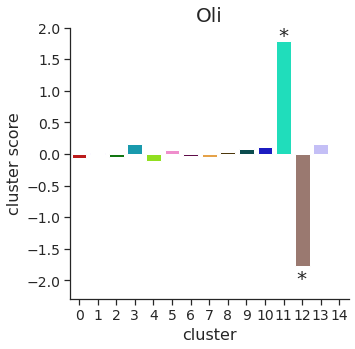

<Figure size 432x288 with 0 Axes>

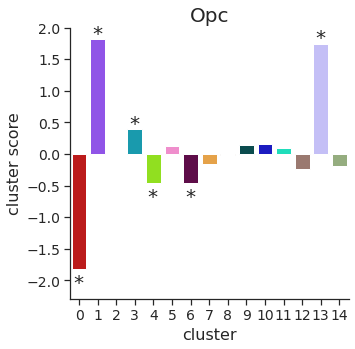

<Figure size 432x288 with 0 Axes>

In [239]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

for name in np.unique(temp['variable']):
    TE = temp.loc[temp['variable']==name]
    plt.figure(figsize = (5,5))

    g = sns.barplot(data=TE,x='cluster', y='value', hue='cluster', palette=palette, dodge=False)
    
    plt.legend([],[], frameon=False)

    for i in range(len(np.array(TE['pval']))):
        p = np.array(TE['pval'])[i]
        v = np.array(TE['value'])[i]
        if (p<0.0001) & (v<0):
            g.text(TE.iloc[i]['cluster']-.3,TE.iloc[i]['value']-0.3,'*', fontsize=20)
        elif (p<0.0001) & (v>0):
            g.text(TE.iloc[i]['cluster']-.3,TE.iloc[i]['value'],'*', fontsize=20)
        #if p<0.001:
        #    g.text(TE.iloc[i]['cluster']-0.2,TE.iloc[i]['value'],'*', fontsize=15)
    sns.despine(top = True, right = True)
    plt.xlabel('cluster', fontsize=16);
    plt.ylabel('cluster score', fontsize=16);
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylim(-2.3,2)
    plt.title(name, fontsize=20)
    plt.savefig('./pdf_figures/cluster_bars' + name + '.pdf')
    plt.figure()